## Capstone Project - The Battle of Neighborhoods: Find an Optimal Chinese Restaurant Location in New York City

### Coursera IBM Data Science Professional Certificate

#### Introduction

New York City is a major metropolitan area in America with more than 8 million people. It has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports.

New York City’s food culture includes an array of international cuisines influenced by the city’s immigrant history. As of 2019, there were 27,043 restaurants in the city. With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, French etc.

For the final assignment of Coursera IBM Data Science Professional Certificate, the business problem is to find an optimal location to open a Chinese restaurant in New York City.

The targeted people who would be interested in this project could be stakeholders who want to open Chinese restaurants in New York City, and tourists who want to enjoy Chinese food in this city.

#### Data

New York City data containing neighborhoods, boroughs, latitudes and longitudes: https://cocl.us/new_york_dataset

New York City neighborhood venues data: Foursquare API

In [1]:
import pandas as pd
import json
from geopy.geocoders import Nominatim
import folium
import requests
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
# download data from https://cocl.us/new_york_dataset and load data
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
# take a quick look at the data
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [4]:
# define a new variable that includes features key
neighborhoods_data = newyork_data['features']

In [5]:
# take a look at the first item in this list
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [6]:
# store the data into a pandas dataframe
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns = column_names)

In [7]:
# take a look at the empty dataframe to confirm that the columns are as intended
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [8]:
# loop through the data and fill the dataframe one row at a time
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index = True)

In [49]:
# examine the resulting dataframe
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [50]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [11]:
# Use geopy library to get the latitude and longitude values of New York City
address = 'New York City, NY'

geolocator = Nominatim(user_agent = 'ny_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [12]:
# create map of New York City using latitude and longitude values and add markers to map
map_newyork = folium.Map(location = [latitude, longitude], zoom_start = 10)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], 
                                           neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(map_newyork)  
    
map_newyork

In [14]:
# define Foursquare credentials and version
CLIENT_ID = 'PIOGOOJSMTP2CTSRPZEFR41SCBX0JQLYMQKC5WCKHAVC4WQF'
CLIENT_SECRET = 'V5JCWID4QAFX423KGIAWNU53EALHH5FD0A4VOTHWHYMEZC4I'
VERSION = '20200421'
LIMIT = 100

print('Foursquare credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Foursquare credentails:
CLIENT_ID: PIOGOOJSMTP2CTSRPZEFR41SCBX0JQLYMQKC5WCKHAVC4WQF
CLIENT_SECRET: V5JCWID4QAFX423KGIAWNU53EALHH5FD0A4VOTHWHYMEZC4I


In [15]:
# create a function to get the top 100 venues in New York City neighborhoods within a radius of 500 meters
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']

        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
NYC_venues = getNearbyVenues(names = neighborhoods['Neighborhood'],
                                   latitudes = neighborhoods['Latitude'],
                                   longitudes = neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [79]:
# check the size of the resulting dataframe
print(NYC_venues.shape)
NYC_venues.head()

(10089, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [80]:
# find out how many unique categories can be curated from all the returned venues
print('There are {} unique categories.'.format(len(NYC_venues['Venue Category'].unique())))

There are 440 unique categories.


In [82]:
# one hot encoding
NYC_onehot = pd.get_dummies(NYC_venues[['Venue Category']], prefix = '', prefix_sep = '')

# add neighborhood column back to dataframe
NYC_onehot['Neighborhood'] = NYC_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NYC_onehot.columns[-1]] + list(NYC_onehot.columns[:-1])
NYC_onehot = NYC_onehot[fixed_columns]

NYC_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# examine the new dataframe size
NYC_onehot.shape

(10089, 440)

In [84]:
# group rows by neighborhoods and by taking the mean of the frequency of occurrence of each category
NYC_grouped = NYC_onehot.groupby('Neighborhood').mean().reset_index()
NYC_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant
0,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
# extract only Neighborhood and Chinese Restaurant columns
NYC_Chinese = NYC_grouped[['Neighborhood', 'Chinese Restaurant']]
NYC_Chinese.head()

,Neighborhood,Chinese Restaurant
0,Allerton,0.038462
1,Annadale,0.000000
2,Arden Heights,0.000000
3,Arlington,0.000000
4,Arrochar,0.000000


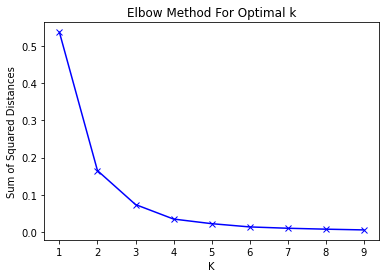

In [86]:
# find the best k for k-means clustering using Elbow Method
NYC = NYC_Chinese[['Chinese Restaurant']]
Sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(NYC)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [87]:
# run k-means clustering to cluster the neighborhood into 3 clusters
kclusters = 3
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(NYC)
kmeans.labels_[0:10] 

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 0])

In [88]:
# add clustering labels
NYC_Chinese.insert(2, 'Cluster Labels', kmeans.labels_)
NYC_Chinese.head()

,Neighborhood,Chinese Restaurant,Cluster Labels
0,Allerton,0.038462,0
1,Annadale,0.000000,2
2,Arden Heights,0.000000,2
3,Arlington,0.000000,2
4,Arrochar,0.000000,2


In [89]:
# merge with New York dataframe so as to get coordinates of all neighborhoods
NYC_Chinese_merged = NYC_Chinese.merge(neighborhoods, how = 'inner', on = 'Neighborhood')
NYC_Chinese_merged.head()

,Neighborhood,Chinese Restaurant,Cluster Labels,Borough,Latitude,Longitude
0,Allerton,0.038462,0,Bronx,40.865788,-73.859319
1,Annadale,0.000000,2,Staten Island,40.538114,-74.178549
2,Arden Heights,0.000000,2,Staten Island,40.549286,-74.185887
3,Arlington,0.000000,2,Staten Island,40.635325,-74.165104
4,Arrochar,0.000000,2,Staten Island,40.596313,-74.067124


In [90]:
# visualize the resulting clusters
map_clusters = folium.Map(location = [latitude, longitude], zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NYC_Chinese_merged['Latitude'], NYC_Chinese_merged['Longitude'], 
                                  NYC_Chinese_merged['Neighborhood'], NYC_Chinese_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

In [91]:
# cluster 0 (red)
NYC_Chinese_merged.loc[NYC_Chinese_merged['Cluster Labels'] == 0]

,Neighborhood,Chinese Restaurant,Cluster Labels,Borough,Latitude,Longitude
0,Allerton,0.038462,0,Bronx,40.865788,-73.859319
9,Bath Beach,0.040816,0,Brooklyn,40.599519,-73.998752
17,Bedford Park,0.090909,0,Bronx,40.870185,-73.885512
19,Beechhurst,0.117647,0,Queens,40.792781,-73.804365
21,Belle Harbor,0.058824,0,Queens,40.576156,-73.854018
...,...,...,...,...,...,...
289,West Farms,0.038462,0,Bronx,40.839475,-73.877745
297,Windsor Terrace,0.037037,0,Brooklyn,40.656946,-73.980073
298,Wingate,0.045455,0,Brooklyn,40.660947,-73.937187
299,Woodhaven,0.040000,0,Queens,40.689887,-73.858110


In [92]:
# cluster 1 (purple)
NYC_Chinese_merged.loc[NYC_Chinese_merged['Cluster Labels'] == 1]

,Neighborhood,Chinese Restaurant,Cluster Labels,Borough,Latitude,Longitude
20,Bellaire,0.166667,1,Queens,40.733014,-73.738892
35,Bronxdale,0.166667,1,Bronx,40.852723,-73.861726
56,Claremont Village,0.130435,1,Bronx,40.831428,-73.901199
79,East Flatbush,0.181818,1,Brooklyn,40.641718,-73.936103
101,Floral Park,0.142857,1,Queens,40.741378,-73.708847
108,Fox Hills,0.250000,1,Staten Island,40.617311,-74.081740
109,Fresh Meadows,0.142857,1,Queens,40.734394,-73.782713
252,Soundview,0.214286,1,Bronx,40.821012,-73.865746
296,Willowbrook,0.250000,1,Staten Island,40.603707,-74.132084


In [93]:
# cluster 2 (light green)
NYC_Chinese_merged.loc[NYC_Chinese_merged['Cluster Labels'] == 2]

,Neighborhood,Chinese Restaurant,Cluster Labels,Borough,Latitude,Longitude
1,Annadale,0.000000,2,Staten Island,40.538114,-74.178549
2,Arden Heights,0.000000,2,Staten Island,40.549286,-74.185887
3,Arlington,0.000000,2,Staten Island,40.635325,-74.165104
4,Arrochar,0.000000,2,Staten Island,40.596313,-74.067124
5,Arverne,0.000000,2,Queens,40.589144,-73.791992
...,...,...,...,...,...,...
294,Williamsbridge,0.000000,2,Bronx,40.881039,-73.857446
295,Williamsburg,0.000000,2,Brooklyn,40.707144,-73.958115
300,Woodlawn,0.000000,2,Bronx,40.898273,-73.867315
302,Woodside,0.012195,2,Queens,40.746349,-73.901842


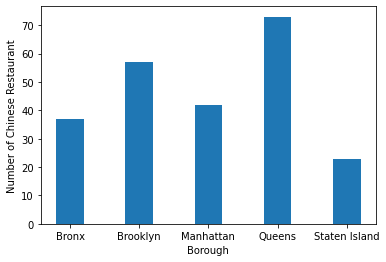

In [132]:
# visualize Chinese restaurants based on borough
NYC_venues_1 = NYC_venues.merge(neighborhoods, how = 'inner', on = 'Neighborhood')
NYC_venues_2 = NYC_venues_1.loc[NYC_venues_1['Venue Category'] == 'Chinese Restaurant']
NYC_venues_3 = NYC_venues_2[['Borough']]
plt.hist(NYC_venues_3['Borough'], bins = np.arange(5 + 1) - 0.5, rwidth = 0.4)
plt.xlabel('Borough')
plt.ylabel('Number of Chinese Restaurant')
plt.show()

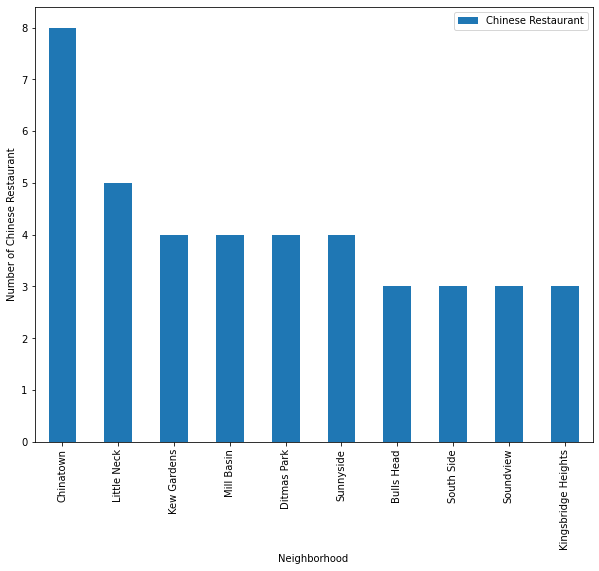

In [133]:
# visualize Chinese restaurants based on neighborhood
graph = pd.DataFrame(NYC_onehot.groupby('Neighborhood')['Chinese Restaurant'].sum())
graph = graph.sort_values(by = 'Chinese Restaurant', ascending = False)
graph.iloc[:10].plot(kind = 'bar', figsize = (10, 8))
plt.xlabel('Neighborhood')
plt.ylabel('Number of Chinese Restaurant')
plt.show()

#### Results

To discuss the results, based on the k-means clustering model and its visualization, Cluster 1 (purple) neighborhoods have the largest density of Chinese restaurants; Cluster 2 (light green) neighborhoods have the least density of Chinese restaurants; Cluster 0 (red) neighborhoods have the middle density of Chinese restaurants. So, the optimal location to open a Chinese restaurant in New York City would be these purple dots on map, as most Chinese restaurants are casual restaurants, and casual restaurants do benefit by clustering near existing ones under the condition that demand is not severely hurt by competition. (To cluster or not to cluster: Understanding geographic clustering by restaurant segment. By Sangwon (Sean) Jung and SooCheong (Shawn) Jang. https://www.sciencedirect.com/science/article/abs/pii/S0278431918302123)

#### Discussions

To discuss any observations noted, based on visualizations of Chinese restaurants based on boroughs and neighborhoods using histograms and bar charts, Queens has a high density of Chinese restaurants, while Chinatown (in Manhattan) has the highest number of Chinese restaurants.

Some drawbacks of this analysis are the clustering is completely based on data fetched from Foursquare API, also the analysis does not take into consideration of the Chinese population across neighborhoods as this can play a huge factor while finding an optimal location to open a Chinese restaurant.

So, the recommendation based on the results for local stakeholders and tourists is to open a casual Chinese restaurant in one of these neighborhoods: Bellaire, Floral Park, Fresh Meadows, as they both satisfy the k-means clustering model as well as observations.


#### Conclusions

To conclude the report, it’s a great opportunity on a business problem, and it’s tackled in a way that it’s similar to how a genuine data scientist would do: using numerous Python libraries to fetch the information, control the content and break down and visualize datasets, using Foursquare API to investigate the settings in neighborhoods of New York City, using different plots present in Matplotlib library, and using Folium to picture on map.

Places that have room for improvement or certain drawbacks meaning that this project can be additionally improved with the assistance of more information and distinctive machine learning strategies. Additionally, this project can be used to investigate any situation, for example, opening an alternate cuisine or opening a movie theater and so forth. Ideally, this project acts as an initial direction to tackle more complex real-life problems using data science.
